##  Model Bias and Fairness Evaluation
Evaluate error metrics(MAE and RMSE) for different subgroups

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

# Custom libraries/methods
from libs import split_data, evaluate_model

In [9]:
# Load dataset
df = pd.read_csv("data/preprocessed/main_ML_ready.csv")
df.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Store_Size,Year,Month,Day,Week,Store_Type_A,Store_Type_B,Store_Type_C
0,1,-0.963831,-1.72052,1.018422,0.078331,False,1,24924.50,0.238802,2010,2,5,5,True,False,False
1,1,-0.963831,-1.72052,1.018422,0.078331,False,2,50605.27,0.238802,2010,2,5,5,True,False,False
2,1,-0.963831,-1.72052,1.018422,0.078331,False,3,13740.12,0.238802,2010,2,5,5,True,False,False
3,1,-0.963831,-1.72052,1.018422,0.078331,False,4,39954.04,0.238802,2010,2,5,5,True,False,False
4,1,-0.963831,-1.72052,1.018422,0.078331,False,5,32229.38,0.238802,2010,2,5,5,True,False,False


In [10]:
# Split the data
X_train, X_test, y_train, y_test = split_data(df, target_column="Weekly_Sales")
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (336169, 15)
y_train shape:  (336169,)
X_test shape:  (84043, 15)
y_test shape:  (84043,)


In [11]:
# Split the test dataset by holiday and non-holiday
holiday_data = X_test[df['IsHoliday'] == True]
non_holiday_data = X_test[df['IsHoliday'] == False]

holiday_target = y_test[df['IsHoliday'] == True]
non_holiday_target = y_test[df['IsHoliday'] == False]


C:\Users\ishar\AppData\Local\Temp\ipykernel_380632\3302728821.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  holiday_data = X_test[df['IsHoliday'] == True]
C:\Users\ishar\AppData\Local\Temp\ipykernel_380632\3302728821.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_holiday_data = X_test[df['IsHoliday'] == False]


In [12]:
def evaluate_bias_fairness(model, X_test, y_test, holiday_data, holiday_target, non_holiday_data, non_holiday_target):
    # Predict on full test data
    y_pred = model.predict(X_test)
    
    # Predict on holiday and non-holiday data
    holiday_pred = model.predict(holiday_data)
    non_holiday_pred = model.predict(non_holiday_data)
    
    # Metrics for full data
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Metrics for holiday and non-holiday subgroups
    holiday_mae = mean_absolute_error(holiday_target, holiday_pred)
    holiday_rmse = np.sqrt(mean_squared_error(holiday_target, holiday_pred))
    
    non_holiday_mae = mean_absolute_error(non_holiday_target, non_holiday_pred)
    non_holiday_rmse = np.sqrt(mean_squared_error(non_holiday_target, non_holiday_pred))
    
    # Compile results
    results = {
        'Full Data': {'MAE': mae, 'RMSE': rmse},
        'Holiday': {'MAE': holiday_mae, 'RMSE': holiday_rmse},
        'Non-Holiday': {'MAE': non_holiday_mae, 'RMSE': non_holiday_rmse}
    }
    
    return results


In [13]:
best_dt_model = DecisionTreeRegressor(
    random_state=42,
    max_depth=None,
    min_samples_leaf=4,
    min_samples_split=10
)

best_rf_model = RandomForestRegressor(random_state=42, n_estimators=200, min_samples_split=2)

best_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8,
    n_estimators=300,     
    learning_rate=0.2,  
    max_depth=6,
    random_state=42,
    min_child_weight= 5,
    subsample=1
)

In [14]:
# Evaluate Decision Tree
best_dt_model.fit(X_train, y_train)
dt_results = evaluate_bias_fairness(best_dt_model, X_test, y_test, holiday_data, holiday_target, non_holiday_data, non_holiday_target)
print("Decision Tree Bias and Fairness Results:", dt_results)

# Evaluate Random Forest
best_rf_model.fit(X_train, y_train)
rf_results = evaluate_bias_fairness(best_rf_model, X_test, y_test, holiday_data, holiday_target, non_holiday_data, non_holiday_target)
print("Random Forest Bias and Fairness Results:", rf_results)

# Evaluate XGBoost
best_xgb_model.fit(X_train, y_train)
xgb_results = evaluate_bias_fairness(best_xgb_model, X_test, y_test, holiday_data, holiday_target, non_holiday_data, non_holiday_target)
print("XGBoost Bias and Fairness Results:", xgb_results)


Decision Tree Bias and Fairness Results: {'Full Data': {'MAE': 1599.5171001705667, 'RMSE': 3916.3132077851137}, 'Holiday': {'MAE': 2583.2004530476406, 'RMSE': 6746.032589700221}, 'Non-Holiday': {'MAE': 1525.9094255020102, 'RMSE': 3616.6035477663877}}
Random Forest Bias and Fairness Results: {'Full Data': {'MAE': 1290.624812325833, 'RMSE': 3195.258480409026}, 'Holiday': {'MAE': 2158.318269688942, 'RMSE': 6308.534063713494}, 'Non-Holiday': {'MAE': 1225.696502280924, 'RMSE': 2827.6585602430364}}
XGBoost Bias and Fairness Results: {'Full Data': {'MAE': 2459.494710272872, 'RMSE': 4430.2437544462355}, 'Holiday': {'MAE': 3196.1603208054294, 'RMSE': 7405.080627281897}, 'Non-Holiday': {'MAE': 2404.3710341010647, 'RMSE': 4122.193772716701}}


In [15]:
# Combine results into a DataFrame
bias_fairness_results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Full Data MAE': [dt_results['Full Data']['MAE'], rf_results['Full Data']['MAE'], xgb_results['Full Data']['MAE']],
    'Full Data RMSE': [dt_results['Full Data']['RMSE'], rf_results['Full Data']['RMSE'], xgb_results['Full Data']['RMSE']],
    'Holiday MAE': [dt_results['Holiday']['MAE'], rf_results['Holiday']['MAE'], xgb_results['Holiday']['MAE']],
    'Holiday RMSE': [dt_results['Holiday']['RMSE'], rf_results['Holiday']['RMSE'], xgb_results['Holiday']['RMSE']],
    'Non-Holiday MAE': [dt_results['Non-Holiday']['MAE'], rf_results['Non-Holiday']['MAE'], xgb_results['Non-Holiday']['MAE']],
    'Non-Holiday RMSE': [dt_results['Non-Holiday']['RMSE'], rf_results['Non-Holiday']['RMSE'], xgb_results['Non-Holiday']['RMSE']]
})

# Display the results
print(bias_fairness_results)


           Model  Full Data MAE  Full Data RMSE  Holiday MAE  Holiday RMSE  \
0  Decision Tree    1599.517100     3916.313208  2583.200453   6746.032590   
1  Random Forest    1290.624812     3195.258480  2158.318270   6308.534064   
2        XGBoost    2459.494710     4430.243754  3196.160321   7405.080627   

   Non-Holiday MAE  Non-Holiday RMSE  
0      1525.909426       3616.603548  
1      1225.696502       2827.658560  
2      2404.371034       4122.193773  


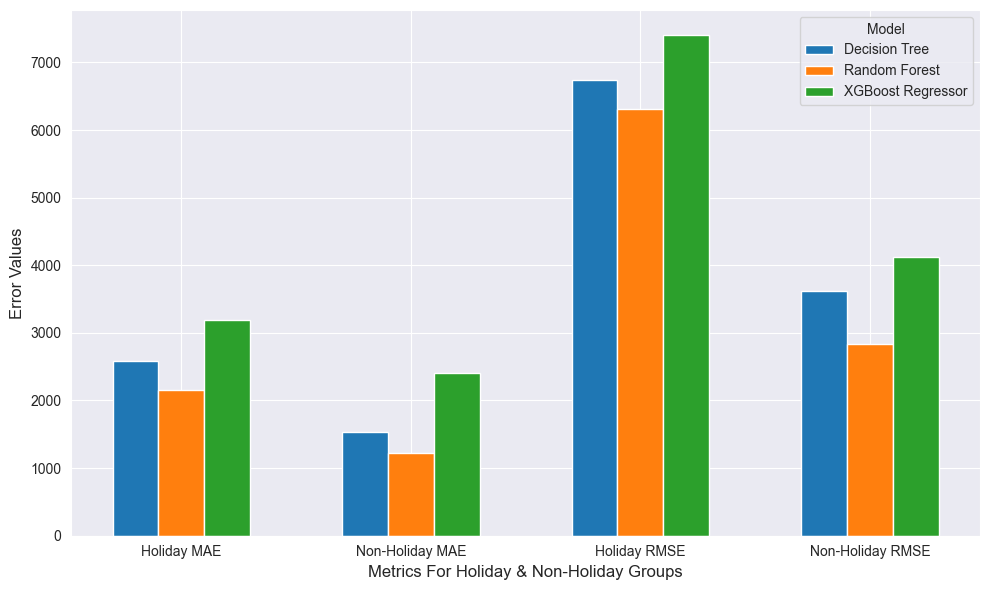

In [19]:
# Data setup (Manually copy-pasted above output values as I cleaned the session and it takes time to execute all models)
models = ['Decision Tree', 'Random Forest', 'XGBoost Regressor']
metrics = ['Holiday MAE', 'Non-Holiday MAE', 'Holiday RMSE', 'Non-Holiday RMSE']
values = [
    [2583.20, 1525.91, 6746.03, 3616.60],  # Decision Tree
    [2158.32, 1225.70, 6308.53, 2827.66],  # Random Forest
    [3196.16, 2404.37, 7405.08, 4122.19]   # XGBoost Regressor
]
values = np.array(values)

# Define plot parameters
bar_width = 0.2
x_indices = np.arange(len(metrics))

# Create a grouped bar plot
plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    plt.bar(
        x_indices + i * bar_width,
        values[i],
        width=bar_width,
        label=model
    )

# Customization
plt.xticks(x_indices + bar_width, metrics, fontsize=10)
plt.ylabel('Error Values', fontsize=12)
plt.xlabel('Metrics For Holiday & Non-Holiday Groups', fontsize=12)
# plt.title('Comparison of MAE and RMSE Across Models', fontsize=14)
plt.legend(title='Model', loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()
